# Классификация - больше инструментов!

> 🚀 В этой практике нам понадобятся: `numpy==1.26.4, pandas==2.2.2, scikit-learn==1.4.2` 

> 🚀 Установить вы их можете с помощью команды: `%pip install numpy==1.26.4 pandas==2.2.2 scikit-learn==1.4.2` 


## Содержание

* [Precision-Recall curve](#Precision-Recall-curve)
* [Receiver operating characteristic кривая](#Receiver-operating-characteristic-кривая)
* [Усреднение показателей по классам](#Усреднение-показателей-по-классам)
* [Мультиклассовая классификация](#Мультиклассовая-классификация)
* [Выводы](#Выводы)
* [Вопросы для закрепления](#Вопросы-для-закрепления)
* [Полезные ссылки](#Полезные-ссылки)


Привет! Сегодня мы продолжаем наше знакомство с инструментами анализа модели классификации.

Наше продолжение коснётся аспекта, который мы открыли для себя в конце прошлой практики - что за вероятности предсказания и почему при росте Precision уменьшается Recall, и наоборот?

Давайте вспомним, что в бинарной классификации мы принимаем решение по уровню вероятности и можем задавать требуемый нам пороговый уровень вероятности, чтобы принимать решение.

Но давайте попробуем суммировать все факты и познакомимся с двумя хорошими способами визуализации, которые покажут интересные зависимости!

In [1]:
# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import sklearn
TEXT_COLOR = "black"

plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["text.color"] = TEXT_COLOR
plt.rcParams["font.size"] = 14
plt.rcParams["lines.markersize"] = 15
plt.rcParams["axes.labelcolor"] = TEXT_COLOR
plt.rcParams["xtick.color"] = TEXT_COLOR
plt.rcParams["ytick.color"] = TEXT_COLOR

sns.set_style("darkgrid")

# Зафиксируем состояние случайных чисел
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

## Precision-Recall curve

Начнём с первой визуализации, которая отражает эту зависимость - при изменении Recall меняется и Precision.

По сути идея заключается в том, чтобы постараться отобразить, как будет меняться сотношение Precision-Recall при любых вариантах порогов.

Так как ранее мы выбирали порог сами и видели конкретные значения, это позволит нам видеть картинку по всему диапазону порогов.

> ⚠️ Ещё раз, PR-Curve позволяет оценить соотношение Precision-Recall на разных уровнях порогов. Это общая **оценка работы модели вне зависимости от порога** на **конкретном классе**. В сравнении, Accuracy, F1 и другие оценивают работу модели при конкретном значении порога принятия решения.

Для рисования нам нужна модель и предсказания. Воспользуемся похожим набором данных, как в прошлой практике:

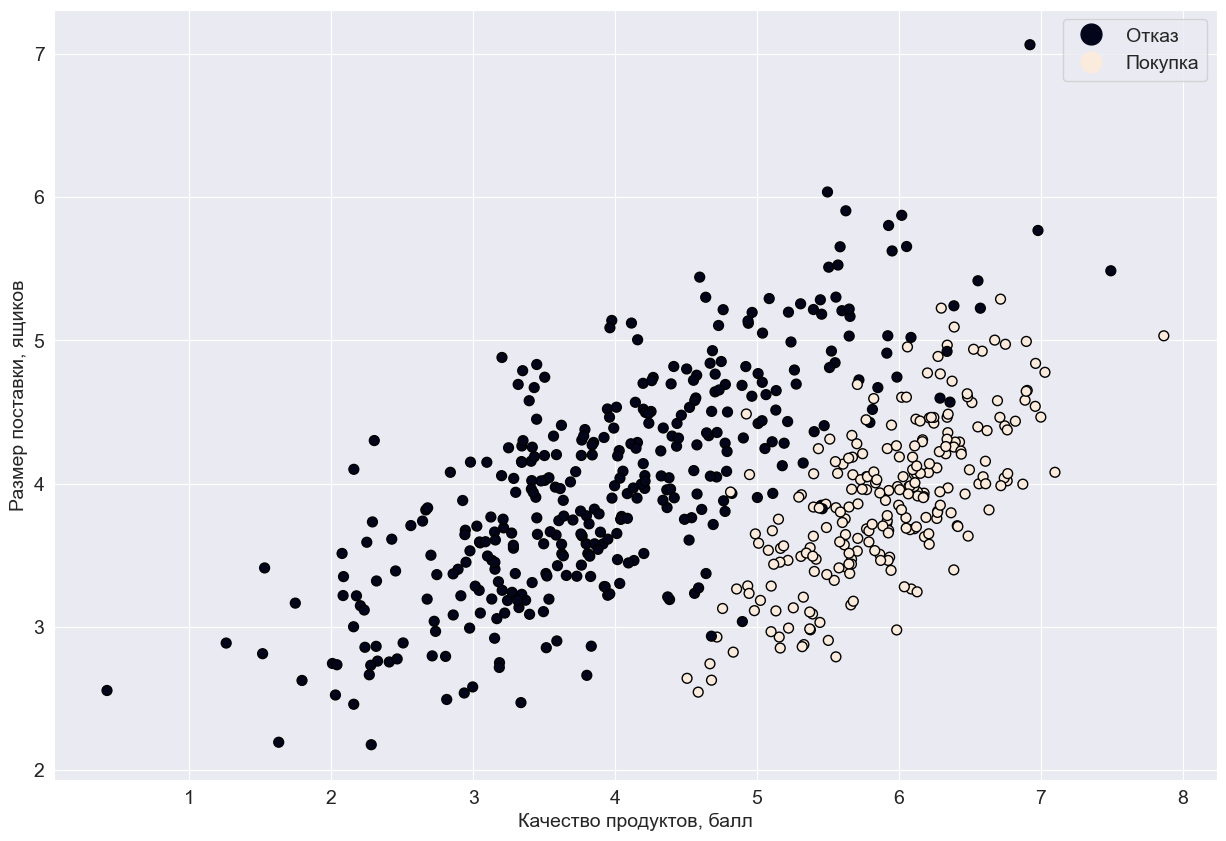

In [2]:
from sklearn.datasets import make_classification

X_data, y_data = make_classification(
    n_samples=600,
    n_features=2, 
    n_redundant=0,
    n_informative=2, 
    n_clusters_per_class=1,
    random_state=RANDOM_SEED,
    shift=[5, 3],
    weights=[0.6, 0.4]
)

df_data = pd.DataFrame(X_data, columns=["Качество", "Размер"])
df_data["Факт покупки"] = y_data
df_data["Факт покупки"] = df_data["Факт покупки"].map({0: "Отказ", 1: "Покупка"})

pnts_scatter = plt.scatter(X_data[:, 0], X_data[:, 1], marker="o", c=y_data, s=50, edgecolor="k")
plt.xlabel("Качество продуктов, балл")
plt.ylabel("Размер поставки, ящиков")
plt.grid(True)
plt.legend(handles=pnts_scatter.legend_elements()[0], labels=["Отказ", "Покупка"])
plt.show()

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

df_train, df_test = train_test_split(df_data, test_size=0.3, stratify=df_data["Факт покупки"], random_state=RANDOM_SEED)

y_train = df_train.pop("Факт покупки")
y_test = df_test.pop("Факт покупки")

target_enc = LabelEncoder()
target_enc.fit(y_train)

y_train_enc = target_enc.transform(y_train)
y_test_enc = target_enc.transform(y_test)

logreg = LogisticRegression(random_state=RANDOM_SEED)
logreg.fit(df_train, y_train_enc)

LogisticRegression(random_state=42)

А теперь отобразим PR кривую с помощью [PrecisionRecallDisplay.from_estimator()](https://scikit-learn.org/1.1/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html#sklearn.metrics.PrecisionRecallDisplay.from_estimator).

Для неё нам потребуется модель и тестовые данные.

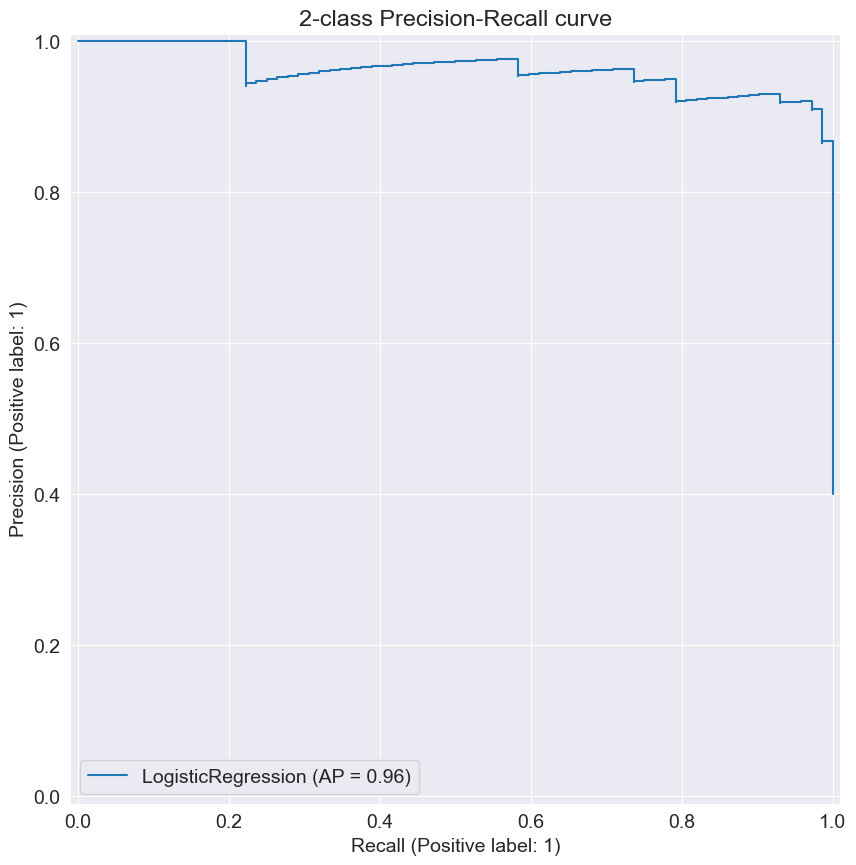

In [4]:
from sklearn.metrics import PrecisionRecallDisplay

disp = PrecisionRecallDisplay.from_estimator(logreg, df_test, y_test_enc)

plt.title("2-class Precision-Recall curve")
plt.show()

Отлично, это и есть график PR-кривой, которая показывает, как меняется Precision в отношении к Recall. Как видите, при увеличении Recall, Precision проседает.

Так, ну это было понятно из опытов, и такая зависимость логична. Что нам график дает?

График позволяет оценить насколько наша модель хороша **в целом** вне зависимости от порога принятия решения!

Только, просто посмотрев на график, мы ничего не поймём, а вот новый тип показателя под названием **Area Under Curve (AUC)** как раз это нам и покажет!

> ⚠️ AUC - величина площади под кривой. Нормирована в диапазоне [0; 1].

То есть наш показатель на этом графике будет называться **PR AUC** и будет показывать, насколько график *прижат* к правому верхнему углу! Чем лучше модель, тем больше будет площадь под кривой, и тем ближе кривая к верхнему правому углу.

А как нам посчитать AUC - это же рисунок!

Для этого мы используем функцию [precision_recall_curve()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) и [auc()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html).

In [7]:
# TODO - напишите функцию pr_auc(), которая принимает y_true - вектор истинных значений, y_probs - матрица вероятностей предсказания, а возвращает auc
#           Обратите внимание, что для precision_recall_curve() требуется вектор вероятностей, а не матрица - вы знаете, как его достать!
def pr_auc(y_true, y_probs):
    from sklearn import metrics
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_probs[:, 1])
    return metrics.auc(recall, precision)

In [8]:
# TEST

_test_y_true = np.array([0, 1, 1, 1, 0])
_test_y_probs = np.array([
    [0.4, 0.6],
    [0.1, 0.9],
    [0.8, 0.2],
    [0.0, 1.0],
    [0.7, 0.3]
])

_test_result_auc = pr_auc(_test_y_true, _test_y_probs)

np.testing.assert_almost_equal(_test_result_auc, 0.85)

print("Well done!")

Well done!


Шикарно, так давайте проверим, какой наш PR AUC модели!

In [9]:
y_probs = logreg.predict_proba(df_test)

logreg_pr_auc = pr_auc(y_test_enc, y_probs)
print(f"PR AUC: {logreg_pr_auc}")

PR AUC: 0.9611869604121152


Отлично, это показывает, что наша модель очень даже неплоха, что имеет такой AUC показатель!

Более того, при расчёте вы, наверное, заметили, что функция [precision_recall_curve()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) возвращает не только точки Pecall и Precision, но также и thresholds, которые им соответствуют. Это позволяет просмотреть значения и выбрать наиболее подходящий порог!

Отличный результат!

## Receiver operating characteristic кривая

Другим важным представлением и показателем является **Receiver operating characteristic (ROC)**. Соответственно, по примеру с предыдущим разделом, существует **ROC curve** и **ROC AUC** показатель.

Начнём, конечно же, с ROC кривой:

Text(0.5, 1.0, 'ROC curve')

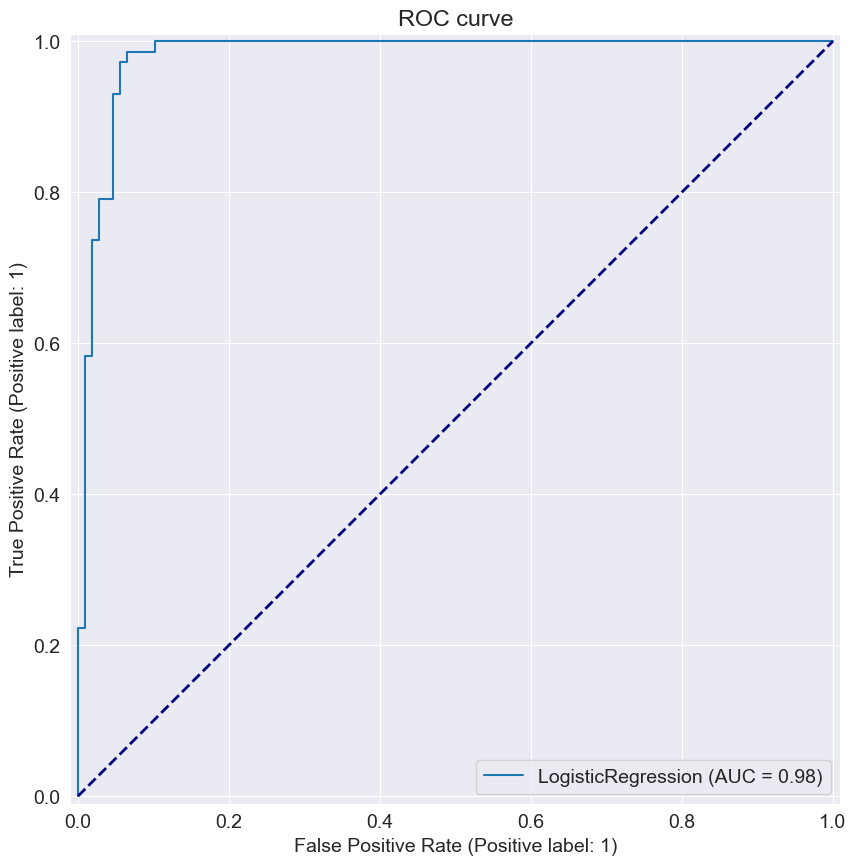

In [10]:
from sklearn.metrics import RocCurveDisplay

disp = RocCurveDisplay.from_estimator(logreg, df_test, y_test_enc, )
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("ROC curve")


Как видите, график похож на PR-curve, но только тянется он к левому верхнему углу. Соответсвенно, AUC здесь оценивается точно также - чем лучше модель в целом, тем ближе кривая к левому верхнему углу, тем больше площадь под кривой!

Только зачем же она нужна, если мы уже можем оценивать PR AUC и выбирать порог по ней?

Во-первых, обратите внимание, что ROC-curve строится в осях **False Positive Rate (FPR - Fall-out)** и **True Positive Rate (TPR - Sensitivity)**. Это ещё два показателя, которые вычисляются для конкретного порога следующим образом:

$$
TPR = \frac{TP}{TP+FN}
$$

$$
FPR = \frac{FP}{FP+TN}
$$

Как видите, TPR - это просто Recall. Ничего нового, а вот FPR - это как раз-таки новый показатель, то есть насколько сильно модель даёт ложные срабатывания. Высокий FPR говорит о том, что модель чаще даёт ложные предсказания положительного класса. А как мы знаем, Recall отражает, насколько полно предсказания соответствуют истинным положительным примерам.

Таким образом, ROC отражает зависимость между полнотой (Sensitivity) и частотой ложных срабатываний.

> Если углубиться и покопать, то можно заметить, что $FPR = 1 - Specificity = 1 - Precision = 1 - \frac{TP}{TP+FP}$. То есть, FPR - это то, насколько модель "неточна" в предсказаниях.

Во-вторых, видите диагональную линию? Это определенный порог, который имеет фиксированный AUC = 0.5 и обозначает модель, предсказывающую всегда случайный класс из двух (типа великий гуру, выбирающий случайный чайник с закрытыми глазами). Если ROC кривая модели ниже этой диагонали - значит, что проще поменять в предсказаниях местами 0 и 1 и тогда показания станут лучше (инверсное поведение).

> Что-то похожее мы видели в регрессии, когда $R^2$ был меньше 0. Модель работает хуже фиксированного простого поведения.

По ROC можно оценить подходящее соотношение полноты предсказаний и количества допустимых ошибок, поэтому это также является полезным инструментом в анализе классификационной модели!

Ну, а теперь - перейдём к расчёту AUC!

In [11]:
# TODO - напишите функцию roc_auc(), которая принимает y_true - вектор истинных значений, y_probs - матрица вероятностей предсказания, а возвращает auc
#           Обратите внимание, что для roc_curve() требуется вектор вероятностей, а не матрица - вы знаете, как его достать!
def roc_auc(y_true, y_probs):
    from sklearn import metrics
    fpr, tpr, _ = metrics.roc_curve(y_true, y_probs[:, 1])
    return metrics.auc(fpr, tpr)

In [12]:
# TEST

_test_y_true = np.array([0, 1, 1, 0])
_test_y_probs = np.array([
    [0.4, 0.6],
    [0.1, 0.9],
    [0.8, 0.2],
    [0.7, 0.3]
])

_test_result_auc = roc_auc(_test_y_true, _test_y_probs)

np.testing.assert_almost_equal(_test_result_auc, 0.5)

print("Well done!")

Well done!


Тааакс, шикарно, теперь посмотрим на наши данные!

In [13]:
logreg_roc_auc = roc_auc(y_test_enc, y_probs)
print(f"ROC AUC: {logreg_roc_auc}")

ROC AUC: 0.981224279835391


Замечательно! Мы смогли разобраться и реализовать ещё пару представлений модели и узнали о новых показателях, которые также могут использоваться для оценки работы модели!

Столько всего нового, но давайте подведём итог:
- Accuracy - простая метрика, зависит от порога принятия решения, оценивает все классы разом. Ненадёжна в случае дисбаланса классов.
- Confusion Matrix - общая картинка предсказаний и ошибок. Зависит от порога принятия решения.
- Recall, Precision, F1 - более детальные показатели поведения модели, зависят от порога принятия решения и оценивают лишь конкретный класс (какой выбран положительным).
- ROC, PR Curves/AUC - визуальные представления с геометрической интерпретацией показателей. Не зависят от порога, так как оценивают по всем возможным порогам. Оценивают только выбранный положительный класс.

Как вы понимаете, показатели, которые зависят от выбора класса в бинарной классификации могут рассчитываться как для класса 1 как положительного, так можно выбрать класс 0 в качестве положительного и посчитать для него.

Получается, у нас для каждого класса могут быть свои F1, ROC AUC и другие? 

Да, всё так, поэтому, мы переходим к теме "А как оценить F1 для всех классов разом?" 

> 🤓 Если вы были внимательны, то могли заметить готовую реализацию [roc_auc_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html). Будет полезно сравнить свой код и готовую реализацию!

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/watson.jpg" width=600/></p>

## Усреднение показателей по классам

Как мы уже выяснили, в таком изобилии показателей на каждый отдельный класс (а представьте, что нам не 2, а 10 классов нужно предсказывать - как? разберём чуть позже) получать своё значение F1 и потом как-то его сравнивать может стать непосильной задачей. 

Вот было бы круто, если бы можно было оценить F1 по всем классам и просто получить один единственный показатель F1 вне зависимости от количества классов?

Есть у меня для вас отличные новости! Такой способ есть!

Давайте начнём с простого, какие варианты приходят на ум?

Что если просто взять, посчитать F1 по каждому классу и взять среднее от них? Выглядит просто, не так ли?

Именно! Это даже называется **macro** усреднение!

Давайте пробовать:

In [14]:
from sklearn.metrics import f1_score

y_pred = logreg.predict(df_test)

# Оценим F1 для класса 1
class1_f1 = f1_score(y_test_enc, y_pred, pos_label=1)

# Оценим F1 для класса 0
class0_f1 = f1_score(y_test_enc, y_pred, pos_label=0)

print(f"F1 scores: 0 [{class0_f1}], 1 [{class1_f1}]")

F1 scores: 0 [0.957345971563981], 1 [0.9395973154362416]


Отлично, вот мы получили два значения F1 для каждого класса, а что теперь? Усредняем!

In [15]:
macro_f1 = (class1_f1+class0_f1)/2
print(f"F1 macro: {macro_f1}")

# Проверяем
macro_sklearn_f1 = f1_score(y_test_enc, y_pred, average="macro")
print(f"F1 macro [sklearn]: {macro_sklearn_f1}")

F1 macro: 0.9484716435001113
F1 macro [sklearn]: 0.9484716435001113


Смотрите, идеально сошлось - мы посчитали F1 с macro усреднением и сделали расчёт с помощью sklearn функции, указав тип усреднения!

Как видите, это один из простых типов усреднения, но даже если сейчас мы делали действия руками, то далее вы сможете просто пользоваться готовой функцией с указанием типа усреднения.

Давайте для пущего проверим, как работает функция [classification_report()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html):

In [16]:
from sklearn.metrics import classification_report

report = classification_report(y_test_enc, y_pred, digits=4)

print(report)

              precision    recall  f1-score   support

           0     0.9806    0.9352    0.9573       108
           1     0.9091    0.9722    0.9396        72

    accuracy                         0.9500       180
   macro avg     0.9448    0.9537    0.9485       180
weighted avg     0.9520    0.9500    0.9502       180



Даже в отчёте видно, что для каждого класса рассчитывается свой Recall, Precision и F1, а затем по одному из методов усреднения делается приведение к среднему.

Такс, **macro** мы освоили, а что такое **weighted**?

Тут немного сложнее, но давайте разберём, а потом реализуем свой расчёт!

**Weighted** метод работает на основе количества примеров класса. То есть, перевод "взвешенное" означает, что учитывается количество примеров, на которое приходится оценка (колонка support).

> 🤓 В этом смысле **macro** можно назвать **unweighted**

Как это можно реализовать? Берём, и для каждого уникального класса в векторе истинных значений находим количество примеров и делим на общее количество примеров выборки - это и будет вес класса. Дальше, находим для каждого класса значение метрики (например, F1) и, умножая на вес, складываем!

Всё просто, давайте делать!

In [17]:
# TODO - реализуйте функцию f1_weighted_score(), которая принимает y_true - вектор разметки, y_pred - вектор предсказаний
#           Использовать f1_score(..., average="weighted") нельзя =)
def f1_weighted_score(y_true, y_pred):
    from sklearn.metrics import f1_score
    classes = np.unique(y_true)
    weights = np.array([np.sum(y_true == c) / len(y_true) for c in classes])
    f1_scores = np.array([f1_score(y_true, y_pred, pos_label=c, average='binary') for c in classes])
    return np.sum(weights * f1_scores)

In [18]:
# TEST

_test_y_true = np.array([0, 1, 1, 0, 1, 1, 0])
_test_y_pred = np.array([1, 0, 1, 1, 0, 1, 0])

_test_result = f1_weighted_score(_test_y_true, _test_y_pred)

np.testing.assert_almost_equal(_test_result, 0.4285714)

print("Well done!")

Well done!


Отлично, значит, теперь нам пора проверить, сходится ли наш расчёт с weighted из sklearn:

In [19]:
weighted_f1 = f1_weighted_score(y_test_enc, y_pred)
print(f"F1 weighted: {weighted_f1}")

# Проверяем
weighted_sklearn_f1 = f1_score(y_test_enc, y_pred, average="weighted")
print(f"F1 weighted [sklearn]: {weighted_sklearn_f1}")

F1 weighted: 0.9502465091128852
F1 weighted [sklearn]: 0.9502465091128853


Отлично! Мы справились! Мы научились двум основным способам усреднения, которые чаще всего применяются в работе!

> ⚠️ Другие способы **micro** и **samples** остаются на самостоятельное рассмотрение.

Но возникает очевидный вопрос: если мы имеем два метода, где какой применять?

Чтобы сразу всё понять, давайте лучше рассмотрим следующий пример:

In [20]:
_example_y_true = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])
_example_y_pred = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

report = classification_report(_example_y_true, _example_y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     1.0000    0.3333    0.5000         3
           1     0.9333    1.0000    0.9655        28

    accuracy                         0.9355        31
   macro avg     0.9667    0.6667    0.7328        31
weighted avg     0.9398    0.9355    0.9205        31



Этот пример несёт две важные особенности:
- присутствует дисбаланс классов - классов 1 явно больше в разы;
- классы с малым количеством примеров явно хуже предсказываются.

Это видно и по метрикам - у класса 0 F1 = 0.5. В свою очередь F1 у класса 1 равен 0.96.

> Обратите внимание, что accuracy тоже очень высок = 0.935.

Ну и в результате, взвешенное среднее дает F1 = 0.92, хотя мы понимаем, что модель работает не очень - класс 0 вообще не может предсказывать.

Вот тут-то нам и важно определить, на какое усреднение ориентироваться - это будет macro или weighted.

Если мы хотим получить от модели хорошие предсказания всех классов, вне зависимости от соотношения количества примеров, то важнее смотреть на macro. Это общая практика, так как даже в этом случае macro показывает - "что-то тут не так".

> ⚠️ Если нам нужна характеристика того, как распределены данные, то можно ориентироваться на weighted из расчёта на то, что раз в данных кейсов меньше, то и в дальнейшей работе их не будет. Но обязательно в этой ситуации учитывайте, что это может быть ошибочным выводом, так как, например, при сборе данных допустили ошибку и примеров класса 0 просто случайно попало мало, но на деле таких случаев много.

Вот таким вот нехитрым способом мы приходим к выводу, что многое может зависеть от задачи и условий, и важно это не упускать!

## Мультиклассовая классификация

Последняя тема, которой мы коснёмся - что же делать в случаях, если классов больше, чем два?

На самом деле, ответ прост - ничего специфичного =)

На данный момент вы уже освоили основные методы и инструменты анализа поведения модели, чтобы уверенно выполнять простую мультиклассовую классификацию.

> 🤓 Тип **мультиклассовый** определяет задачу как "выбрать один из возможных классов". Существует другая задача, которую мы не рассматриваем **мультиименная** классификация, в которой предсказание может содержать несколько классов. Примером такой задачи может быть "присваивание тэгов картинкам". На изображении может быть собачка, кошечка и тапки. Не исключается, что на изображении могут быть как все три, так и ни одного.

Давайте для примера рассмотрим данные, которые содержат три класса и попробуем поработать с ними:

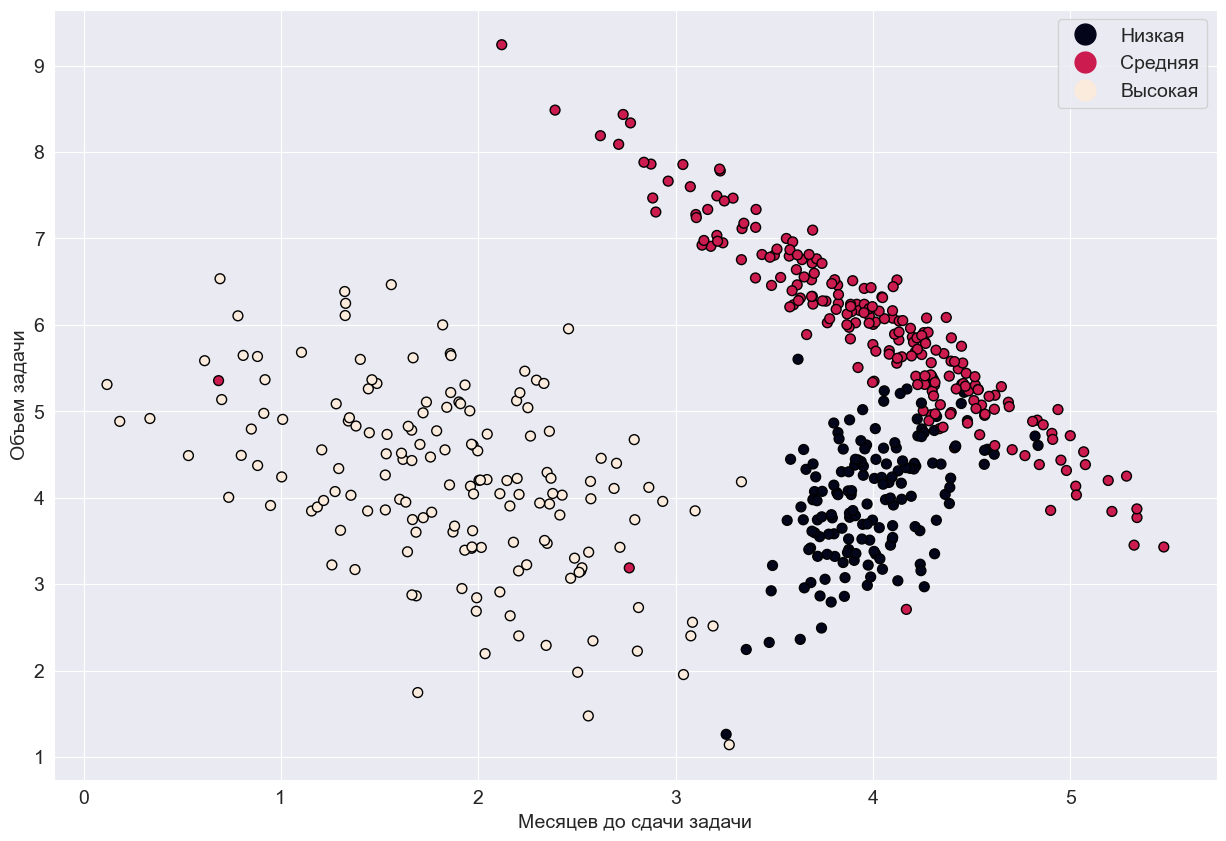

In [21]:
X_data, y_data = make_classification(
    n_samples=530,
    n_features=2, 
    n_classes=3,
    n_redundant=0,
    n_informative=2, 
    n_clusters_per_class=1,
    random_state=RANDOM_SEED,
    shift=[5, 3],
    weights=[0.3, 0.4, 0.3]
)

df_data = pd.DataFrame(X_data, columns=["Срок сдачи, мес", "Объем задачи"])
df_data["Критичность"] = y_data
df_data["Критичность"] = df_data["Критичность"].map({0: "Низкая", 1: "Средняя", 2: "Высокая"})

pnts_scatter = plt.scatter(X_data[:, 0], X_data[:, 1], marker="o", c=y_data, s=50, edgecolor="k")
plt.xlabel("Месяцев до сдачи задачи")
plt.ylabel("Объем задачи")
plt.grid(True)
plt.legend(handles=pnts_scatter.legend_elements()[0], labels=["Низкая", "Средняя", "Высокая"])
plt.show()

Для примера, имеется набор данных по классификации критичности задачи, наша задача - предсказать критичность заявки. Как видите, классов больше двух, поэтому это является мультиклассовой классификацией.

Мы пропустим этапы анализа данных, так как наша цель - разобраться с тем, что делать в случае множества классов.

> ⚠️ В реальной задаче разработки никогда не пренебрегайте анализом данных. Это один из важнейших этапов!

In [22]:
df_data

,"Срок сдачи, мес",Объем задачи,Критичность
0,3.102820,7.277037,Средняя
1,4.100934,6.077354,Средняя
2,2.688461,4.107042,Высокая
3,5.285337,4.249883,Средняя
4,4.564485,4.386474,Низкая
...,...,...,...
525,3.691281,3.612668,Низкая
526,3.791840,6.478120,Средняя
527,4.099952,3.676774,Низкая
528,3.898552,3.851229,Низкая


In [23]:
df_data["Критичность"].value_counts()

Критичность
Средняя    215
Высокая    158
Низкая     157
Name: count, dtype: int64

С точки зрения подготовки целевой колонки, если она имеет строковый тип, ничего не меняется - также применяем [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

> 🔥 В примерах мы часто импортировали модули по мере надобности, но лучшая практика - импортировать в начале ноутбука все необходимые модули и далее использовать их. Если вы при разработке поняли, что чего-то не хватает - добавьте в начало и перезапустите ноутбук. Так вы ещё проверите, что весь наработанный эксперимент **воспроизводим**, что тоже очень важное свойство при разработке!

In [25]:
df_train, df_test = train_test_split(df_data, test_size=0.3, stratify=df_data["Критичность"], random_state=RANDOM_SEED)

y_train = df_train.pop("Критичность")
y_test = df_test.pop("Критичность")

target_enc = LabelEncoder()
target_enc.fit(y_train)

y_train_enc = target_enc.transform(y_train)
y_test_enc = target_enc.transform(y_test)

print(f"Train/test shapes: {df_train.shape}, {df_test.shape}")
print(target_enc.classes_)

Train/test shapes: (371, 2), (159, 2)
['Высокая' 'Низкая' 'Средняя']


In [26]:
# Обучаем модель
logreg = LogisticRegression(random_state=RANDOM_SEED)
logreg.fit(df_train, y_train_enc)

# Смотрим на метрики
y_pred = logreg.predict(df_test)

# Обратите внимание, для отображения можно взять классы из LabelEncoder и подставить для отображения
report = classification_report(y_test_enc, y_pred, target_names=target_enc.classes_)
print(report)

              precision    recall  f1-score   support

     Высокая       1.00      0.96      0.98        47
      Низкая       0.88      0.74      0.80        47
     Средняя       0.84      0.95      0.89        65

    accuracy                           0.89       159
   macro avg       0.90      0.89      0.89       159
weighted avg       0.90      0.89      0.89       159



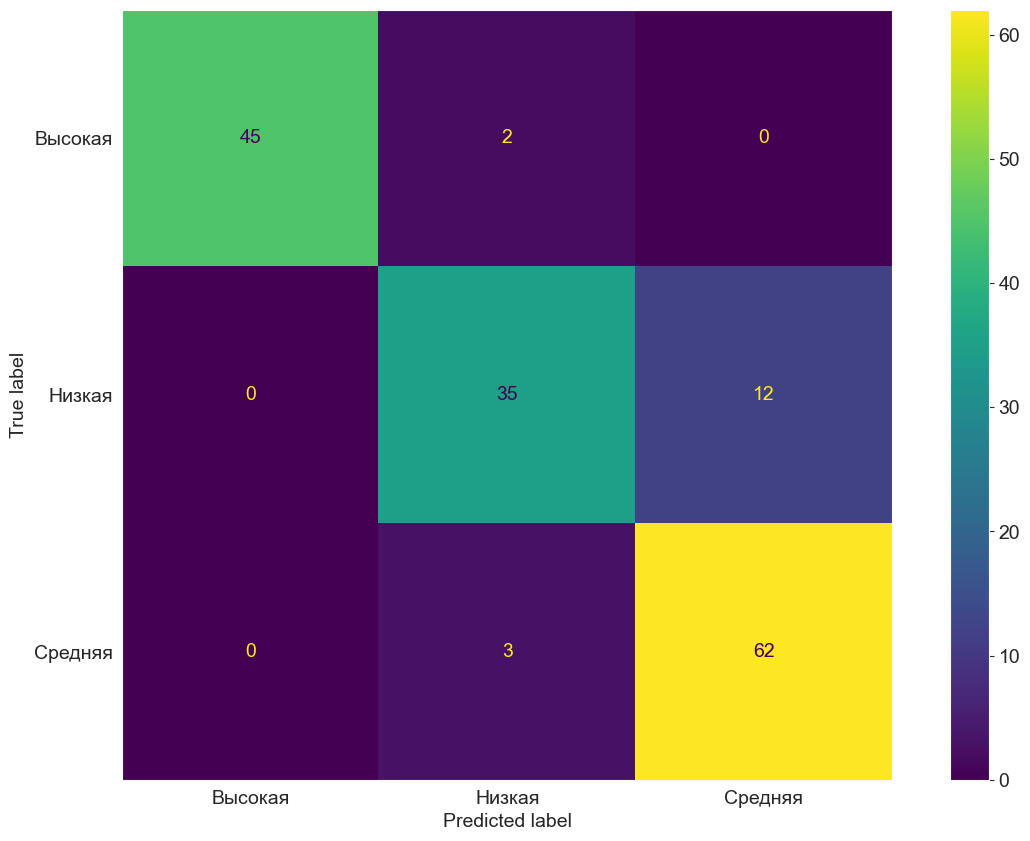

In [27]:
# Визуализируем Confusion matrix
y_pred = logreg.predict(df_test)
cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=target_enc.classes_)
disp.plot()
plt.grid(False)
plt.show()

А вот с ROC/PR придется повозиться - так как они реализованы только для бинарной классификации, нам нужно превратить вектор `[0, 1, 2, 1, 2, 0]` в матрицу, которая содержит только 0 и 1 - бинаризовать!

In [28]:
from sklearn.preprocessing import label_binarize

print(f"y_test before:\n{y_test_enc[:10]}")

y_test_enc_bin = label_binarize(y_test_enc, classes=np.unique(y_test_enc))

print(f"y_test after:\n{y_test_enc_bin[:10]}")


y_test before:
[0 2 1 2 1 2 1 1 1 2]
y_test after:
[[1 0 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]]


Вектор индексов классов превратился в матрицу, в которой единица стоит на месте, соответствующем номеру индекса. Это поможет нам нарисовать кривые!

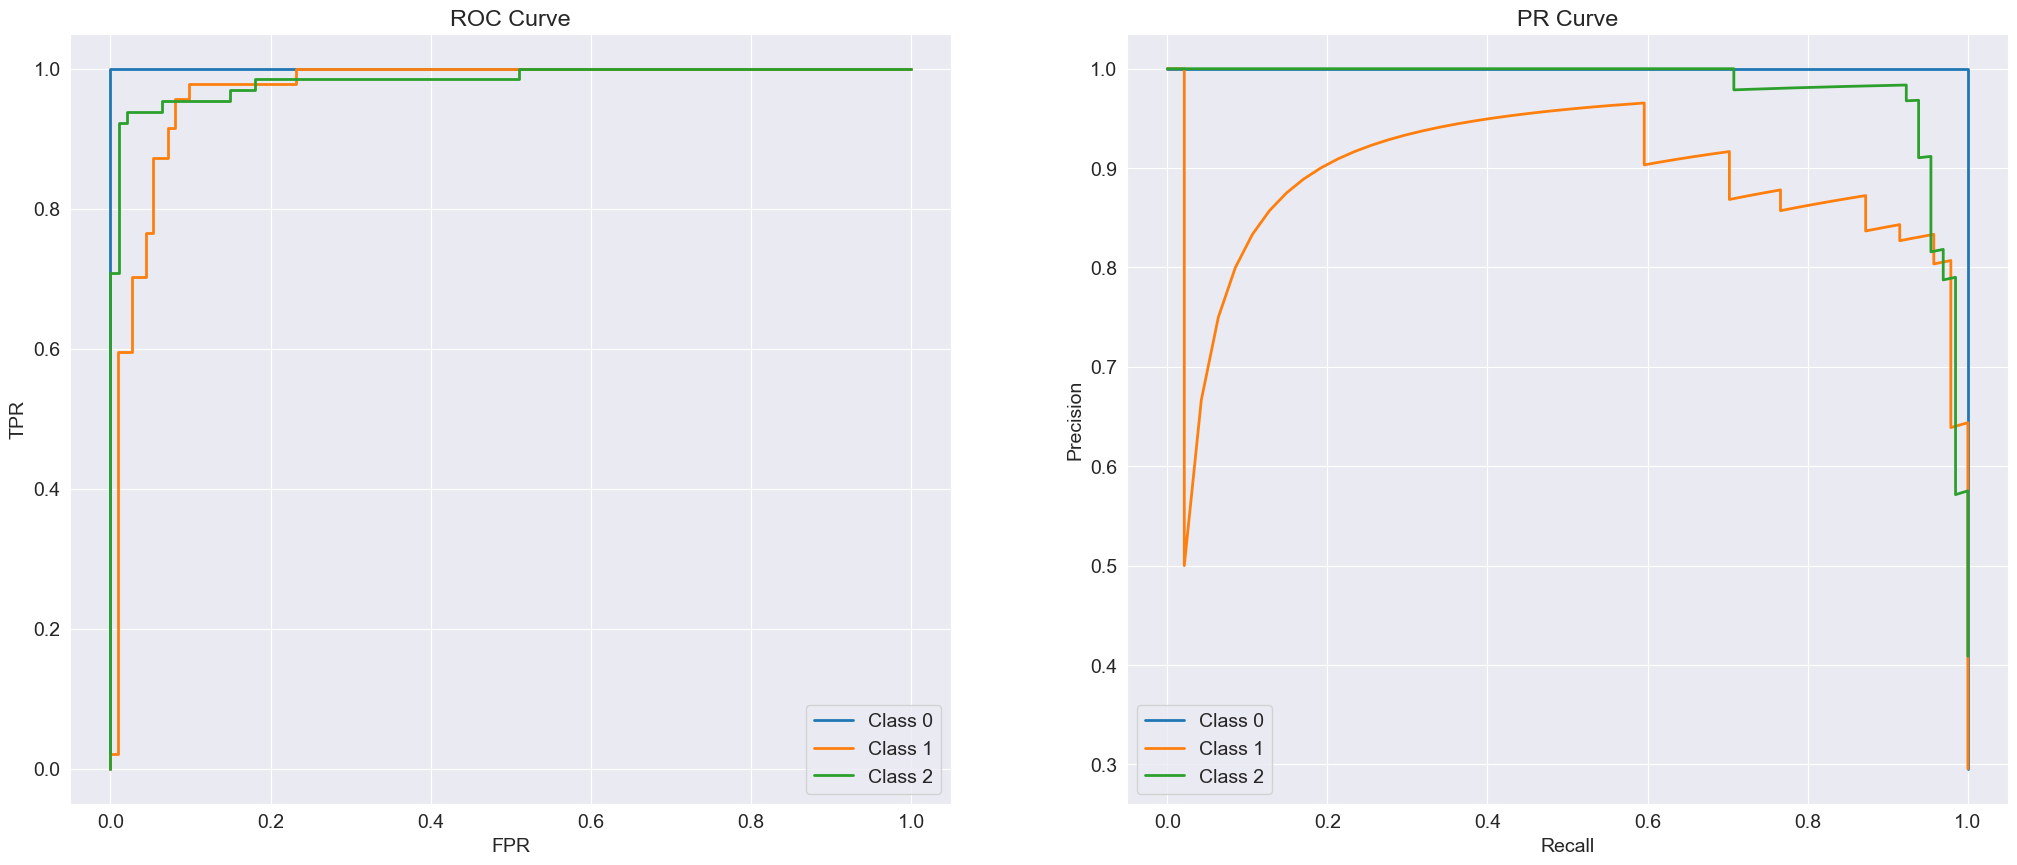

In [29]:
# Рисуем ROC, PR curves
from sklearn.metrics import precision_recall_curve, roc_curve

y_probs = logreg.predict_proba(df_test)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))

for cls_ in np.unique(y_test_enc):
    fpr, tpr, _ = roc_curve(y_test_enc_bin[:, cls_], y_probs[:, cls_])
    precision, recall, _ = precision_recall_curve(y_test_enc_bin[:, cls_], y_probs[:, cls_])
    ax[0].plot(fpr, tpr, lw=2, label=f"Сlass {cls_}")
    ax[1].plot(recall, precision, lw=2, label=f"Сlass {cls_}")

ax[0].set_title("ROC Curve")
ax[0].set_xlabel("FPR")
ax[0].set_ylabel("TPR")
ax[0].legend()

ax[1].set_title("PR Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].legend()

plt.show()

Как видим, удалось нарисовать кривые ROC/PR, аналогичным образом строятся и показатели ROC/PR AUC.

Таким образом, мультиклассовая классификация при использовании инструментария `sklearn` не составляет сложности. 

Важно понимать, что внутри модели при количестве классов больше двух применяется не просто пороговое значение, а скорее индекс максимальной вероятности, но метод `predict_proba()` всё также существует и позволяет делать с вероятностями что вздумается!

## Выводы

Вот мы и научились работать с моделями как c бинарной, так и c мультклассовой классификациями. Кроме того, мы всячески изучили поведение модели по результатам обучения. 

Конечно, инструментов много и, как видите, обучить модель делать какие-то предсказания не так сложно. В этом есть правда, так как основной результат улучшения хранится не в самой модели, а в тех данных, на которых она обучается!

Поэтому, завершая изучение анализа поведения классифицирующей модели, мы переходим к реальному датасету и способам анализа данных в случаях, когда целевая колонка представлена категориальной!

## Вопросы для закрепления

А теперь пара вопросов, чтобы закрепить материал!

1. Почему в [classification_report()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) accuracy стоит отдельно и не усредняется?
2. Какой размер матрицы вероятностей предсказания (probs), если модель обучена на предсказание пяти классов, а в выборке 5000 примеров?
3. Как тип классификации будет, если нам нужно находить хомяка, кота и попугая на изображении? 
4. На какое усреднение стоит опираться, если в данных есть дисбаланс классов? 
5. Что означает, если кривая AUC стремится к правому нижнему углу? 

## Полезные ссылки
* [ROC and AUC Curves от StatQuest](https://www.youtube.com/watch?v=4jRBRDbJemM)
